In [1]:
import random

from data_generator.csv_data_processor import CSVDataProcessor
from utils.util_funcs import create_distributed_age_df
from utils.udf_functions import create_random_dob_pandas_udf, create_fake_name_udf, random_gender_pd_udf, choose_blood_type_udf
from utils.read_write import read_postgres_table
from spark_instance import spark
from pyspark.sql import Window

from pyspark.sql.functions import col, lower, rand, array,row_number, concat_ws, date_format, sum, udf
  

24/04/16 22:10:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/Users/jacobbickerstaff/Desktop/Development/health-data-etl-kaggle/venv/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
average_age = 40.1

csv_age_file_file = CSVDataProcessor(spark, "data/uk_age_population.csv")

csv_age_uk_df = csv_age_file_file.runner()

In [3]:
csv_age_uk_df.show()

+----------+--------------------+--------------+----------+-----+--------+------+---+--------------------+----------------+
|sourceyear|              author|      location|       sex|ageid|agestart|ageend|age|        estimatetype|population_total|
+----------+--------------------+--------------+----------+-----+--------+------+---+--------------------+----------------+
|      2022|United Nations Po...|United Kingdom|Both sexes|   42|       0|     1|  0|Model-based Estim...|          678115|
|      2022|United Nations Po...|United Kingdom|Both sexes|   89|       1|     1|  1|Model-based Estim...|          679828|
|      2022|United Nations Po...|United Kingdom|Both sexes|  117|       2|     2|  2|Model-based Estim...|          682987|
|      2022|United Nations Po...|United Kingdom|Both sexes|  126|       3|     3|  3|Model-based Estim...|          702265|
|      2022|United Nations Po...|United Kingdom|Both sexes|  135|       4|     4|  4|Model-based Estim...|          733315|
|      2

In [4]:
import math

# Calculate the squared differences from the known mean, weighted by the population total
csv_age_uk_sq_df = csv_age_uk_df.withColumn("weighted_squared_diff", (col("age") - 40.2) ** 2 * col("population_total"))

# Sum up the weighted squared differences and the total population
total_weighted_squared_diff = csv_age_uk_sq_df.select(sum("weighted_squared_diff")).collect()[0][0]
total_population = csv_age_uk_sq_df.select(sum("population_total")).collect()[0][0]

# Calculate the weighted variance
weighted_variance = total_weighted_squared_diff / total_population

# Calculate the weighted standard deviation
weighted_standard_deviation = math.sqrt(weighted_variance)

print("Weighted Standard Deviation of Age:", weighted_standard_deviation)


Weighted Standard Deviation of Age: 23.868386921247534


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


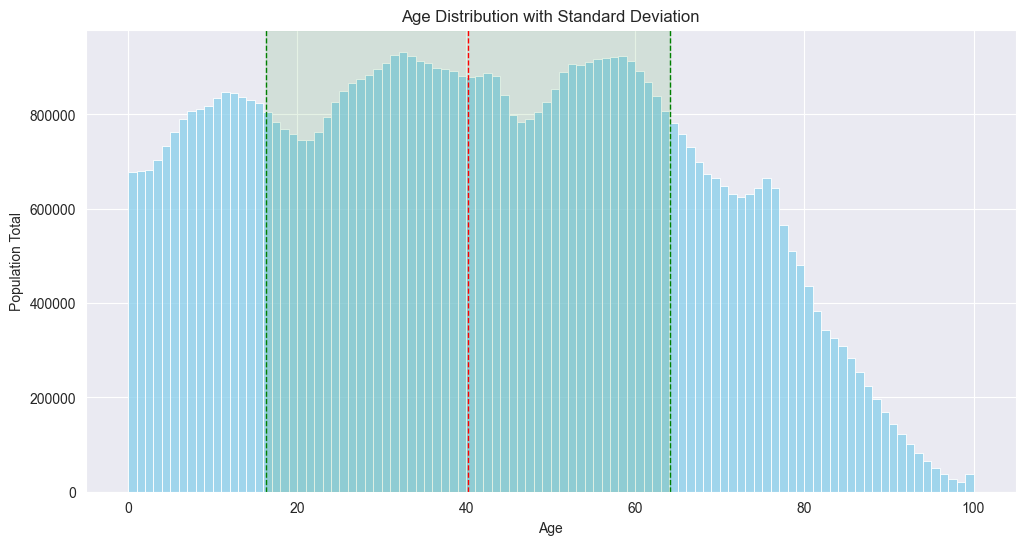

In [6]:

pandas_df = csv_age_uk_sq_df.toPandas()

mean_age = 40.2

pandas_df['age'] = pandas_df['age'].astype(float)
pandas_df['population_total'] = pandas_df['population_total'].astype(int)
pandas_df['weighted_squared_diff'] = pandas_df['population_total'] * (pandas_df['age'] - mean_age) ** 2

total_weighted_squared_diff = np.sum(pandas_df['weighted_squared_diff'])
total_population = np.sum(pandas_df['population_total'])

weighted_variance = total_weighted_squared_diff / total_population
standard_deviation = np.sqrt(weighted_variance)


plt.figure(figsize=(12, 6))
sns.histplot(pandas_df, x='age', weights='population_total', bins=range(int(pandas_df['age'].min()), int(pandas_df['age'].max()) + 1), color='skyblue', kde=False)

plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mean_age + standard_deviation, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_age - standard_deviation, color='green', linestyle='dashed', linewidth=1)

plt.axvspan(float(mean_age) - standard_deviation, float(mean_age) + standard_deviation, alpha=0.1, color='green')

plt.title('Age Distribution with Standard Deviation')
plt.xlabel('Age')
plt.ylabel('Population Total')
plt.show()



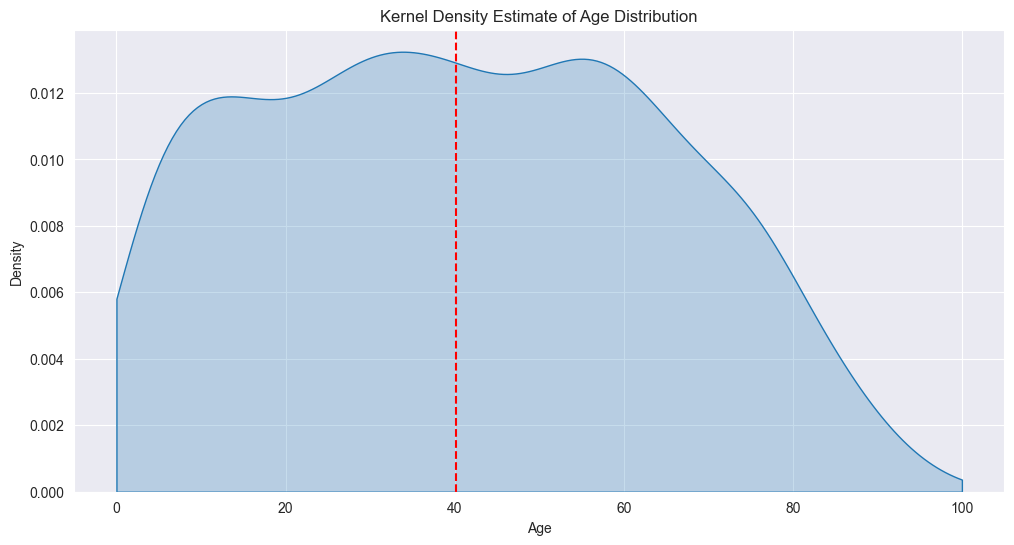

In [7]:


# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create the KDE plot
sns.kdeplot(data=pandas_df, x='age', weights='population_total', fill=True, common_norm=False, bw_adjust=0.5, clip=(pandas_df['age'].min(), pandas_df['age'].max()))

plt.axvline(x=40.2, color='r', linestyle='--')

plt.title('Kernel Density Estimate of Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')

# Show the plot
plt.show()


In [2]:
sampled_df = create_distributed_age_df(spark,  "data/uk_age_population.csv")

In [3]:
sampled_df.show()

+---+
|Age|
+---+
|  8|
| 25|
| 13|
| 37|
| 29|
| 51|
| 38|
|  3|
| 73|
| 25|
| 42|
| 80|
| 10|
| 55|
|  7|
| 46|
|  3|
| 82|
| 37|
| 46|
+---+


In [6]:
from pyspark.sql.functions import lit

is_female = lower(col('gender')) == 'female'
is_pediatric = col("Age") < 18
is_geriatric = (col("Age") >= 65)

sampled_df = sampled_df.withColumn("size", lit(1))
sampled_df_with_name = (sampled_df.withColumn("name", create_fake_name_udf(col("size")))
                                           .withColumn("DOB", create_random_dob_pandas_udf(col("Age")))
                                           .withColumn("gender", random_gender_pd_udf(lit("uk")))
                                           .withColumn("blood_type", choose_blood_type_udf(col("size")))
                                           .withColumn("is_female", is_female)
                                           .withColumn("is_pediatric", is_pediatric)
                                           .withColumn("is_geriatric", is_geriatric)
                        .drop("size"))

In [7]:
sampled_df_with_name.show(n=20000)

+---+--------------------+----------+------+----------+---------+------------+------------+
|Age|                name|       DOB|gender|blood_type|is_female|is_pediatric|is_geriatric|
+---+--------------------+----------+------+----------+---------+------------+------------+
| 48|        V. Mcpherson|1976-02-28|  Male|        O-|    false|       false|       false|
| 82|           C. Butler|1941-11-12|  Male|        O+|    false|       false|        true|
| 53|            Q. Smith|1970-10-06|  Male|        O+|    false|       false|       false|
| 42|            A. Pitts|1981-05-08|Female|        A-|     true|       false|       false|
| 16|         V. G. Davis|2007-06-13|Female|        A+|     true|        true|       false|
| 61|    N. A. A. Hopkins|1962-10-25|  Male|        O+|    false|       false|       false|
| 39|            M. Evans|1985-01-09|  Male|        O-|    false|       false|       false|
| 59|          V. Pearson|1965-04-03|  Male|        O-|    false|       false|  

In [ ]:
# will be scrapping this shortly 
# csv_reader = CSVDataProcessor(spark, "data/healthcare_dataset.csv")

# # Read the CSV file
# raw_df = csv_reader.run()


In [16]:
# above is commented out as it's saved in the database:
df = read_postgres_table("dob_age_raw_data")

In [ ]:
from constants.admission_types_dataset import admission_mapping, AdmissionTypes
flattened = [
    (
        top_level.name,
        sub_level_key.name,
        list(sub_level_info.get("stay_types")),
        sub_level_info.get("tests"),  
        random.choice(sub_level_info.get("doctors"))
    )
    for top_level, sub_level_dict in admission_mapping.items()
    for sub_level_key, sub_level_info in sub_level_dict.items()
]



In [ ]:
flattened

In [ ]:
from constants.condition_probabilities import condition_age_probability_dict

flattened_condition_probabilities = [
    (
        sub_admission,
        condition,
        gender if gender in ['male', 'female'] else None,
        float(age_range[0]),
        float(age_range[1]) if len(age_range) > 1 else float('inf'),
        float(probability) 
    )
    for sub_admission, conditions in condition_age_probability_dict.items()
    for condition, genders_or_age_prob_list in conditions.items()
    for gender, age_prob_list in (genders_or_age_prob_list.items() if isinstance(genders_or_age_prob_list, dict) else [(None, genders_or_age_prob_list)])
    for age_range, probability in age_prob_list
]



In [ ]:
flattened_condition_probabilities

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType

columns = ["condition_admission_type", "condition", "gender", "age_min", "age_max", "probability"]
schema = StructType([
    StructField("condition_admission_type", StringType(), True),
    StructField("condition", StringType(), True),
    StructField("condition_gender", StringType(), True),  # Assuming gender can be specific probability for gender 'male', 'female', or null
    StructField("age_min", FloatType(), False),
    StructField("age_max", FloatType(), False),
    StructField("probability", FloatType(), False)
])



condition_prob_df = spark.createDataFrame(data=flattened_condition_probabilities, schema=schema)


In [ ]:
condition_prob_df.show()

In [ ]:
df.show()

In [ ]:
"""
STEP 1 
    From the flattened data list we wish to create a DataFrame. This contains all the possible combinations for the given 
    top level admissions, sub level admissions, stay types and list of tests available from the admission_mapping, stay_type and admission_tests lists or dictionaries in admission_types_test_dataset.py
"""

mapping_df = spark.createDataFrame(flattened, ["top_level_admission", "sub_level_admission", "stay_types", "possible_tests", "doctor"])

joined_tbl = mapping_df.join(condition_prob_df, on=[mapping_df.sub_level_admission == condition_prob_df.condition_admission_type], how="left")

In [ ]:
"""
STEP 2 
    Create a list of admission_types randomly assign this to the original patient in the original data set, 
    whilst dropping the original admission_type column. Then join with mapping_df on top_level_admission col to give access to possible 
    conditions, mappings and so on.
"""
admission_type_names = [member.name for member in AdmissionTypes]

keys_array = array([lit(name) for name in admission_type_names])

# Define constants and conditions
female_only = ["MATERNITY", 'obstetrics']
is_female = lower(col('gender')) == 'female'
is_pediatric = col("Age") < 18
is_geriatric = (col("Age") >= 65)

df = (df.withColumn("is_female", is_female)
        .withColumn("is_pediatric", is_pediatric)
        .withColumn("is_geriatric", is_geriatric)
        .withColumn("unique_id", concat_ws("_", "name", date_format("DOB", "yyyyMMdd")))
        .drop("doctor", "medical_condition", "test_results", "medication", "admission_type")
      )



In [17]:
df.show()

+--------------------+---+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+----------+
|                name|Age|gender|blood_type|medical_condition|date_of_admission|            doctor|            hospital|insurance_provider|    billing_amount|room_number|admission_type|discharge_date| medication|test_results|       DOB|
+--------------------+---+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+----------+
|     Tiffany Ramirez| 39|Female|        O-|         Diabetes|       2022-11-17|    Patrick Parker|    Wallace-Hamilton|          Medicare| 37490.98336352819|        146|      Elective|    2022-12-01|    Aspirin|Inconclusive|1984-09-30|
|         Ruben Burns| 16|  Male|        O+|        

In [ ]:
"""
STEP 3  
Create Enum class df and join it on to main driver df. 
Then create conditions 
"""

from data_generator.conditions_creator import ConditionsCreator
from utils.thread_operations import runner
from constants.type_constants import SubAdmissionTypes

enum_values = [e.name for e in SubAdmissionTypes]

enum_df = spark.createDataFrame(enum_values, StringType()).toDF("admission_type")



selected_conditions_df = runner(spark, ConditionsCreator, df, joined_tbl, enum_df)


In [ ]:
# TODO:  
# tests to be chosen
#  admission date to be chosen 


In [ ]:
spark.stop()